**Exercise 1**

In [1]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
def display_image(title, image):
    plt.figure(figsize=(4,4))
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

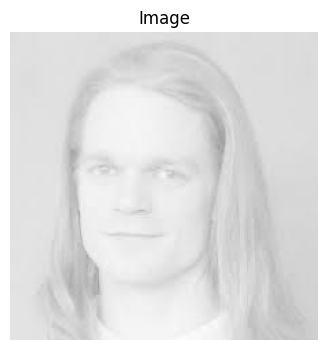

In [25]:
image = cv2.imread('image3.jpeg', cv2.IMREAD_GRAYSCALE)

M1_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
display_image('Image', M1_rgb)

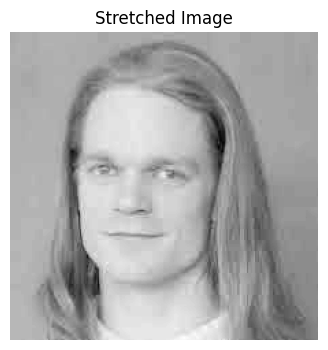

In [26]:
def contrast_stretching(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched = (image - min_val) * (255 / (max_val - min_val))
    return stretched.astype(np.uint8)

stretched_image = contrast_stretching(image)
display_image('Stretched Image', stretched_image)

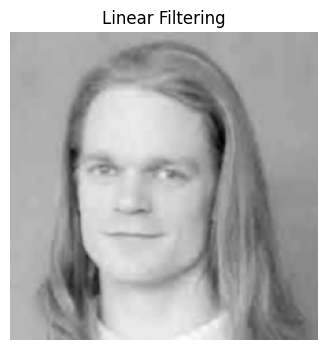

In [30]:
filtered_image = cv2.GaussianBlur(stretched_image, (3,3), 0)
display_image('Linear Filtering', filtered_image)

In [27]:
def plot_histogram(image, title):
    plt.hist(image.ravel(), bins=256, range=[0,256], color='gray')
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

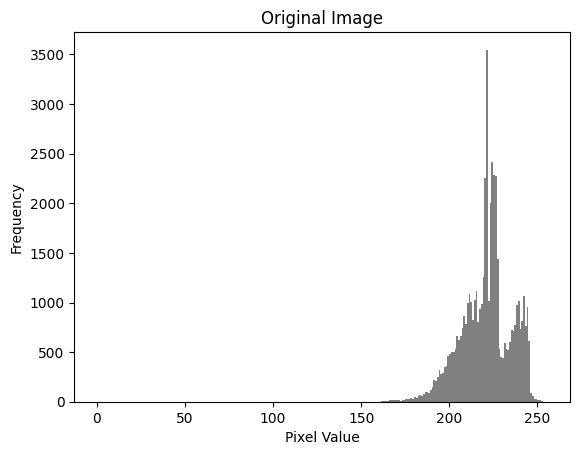

In [28]:
plot_histogram(image, 'Original Image')

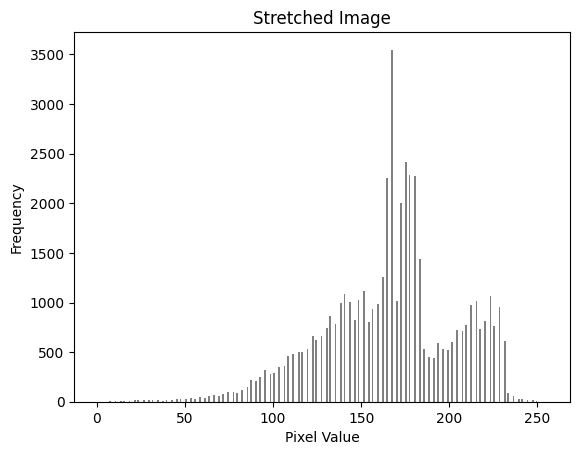

In [29]:
plot_histogram(stretched_image, 'Stretched Image')

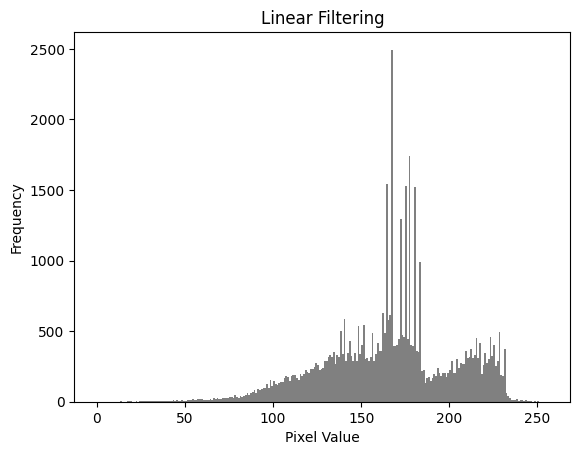

In [31]:
plot_histogram(filtered_image, 'Linear Filtering')

**Exercise 2**

In [1]:
data_dir = 'horse-or-human'

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        print(label_dir)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, file)
                if img_path.endswith(('png')):
                    img = load_img(img_path, target_size=(150, 150))
                    img_array = img_to_array(img) / 255.0
                    images.append(img_array)
                    labels.append(label)
    print(f'Total images: {len(images)}')
    return np.array(images), np.array(labels)

images, labels = load_images_from_directory(data_dir)

horse-or-human\horses
horse-or-human\humans
Total images: 1027


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
print(f'Train set: {X_train.shape[0]} images')
print(f'Test set: {X_test.shape[0]} images')

Train set: 821 images
Test set: 206 images


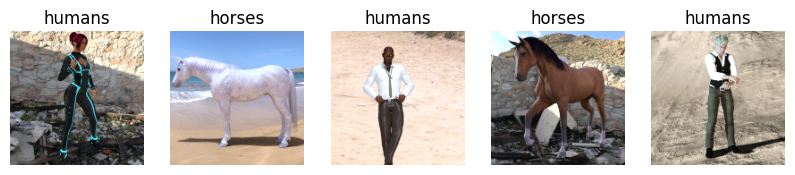

In [5]:
import matplotlib.pyplot as plt

def display_samples(images, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

display_samples(X_train, y_train)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import models

def build_transfer_model(base_model, neurons=128, dropout_rate=0.3):
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
from tensorflow.keras.optimizers import Adam

def compile_and_train(model, learning_rate=0.01, batch_size=32, epochs=5):
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=epochs, batch_size=batch_size, verbose=1)
    return history

In [11]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()


Evaluating ResNet50

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5304 - loss: 1.0446 - val_accuracy: 0.5146 - val_loss: 0.6792
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5478 - loss: 0.6747 - val_accuracy: 0.6650 - val_loss: 0.6239
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7017 - loss: 0.5949 - val_accuracy: 0.6165 - val_loss: 0.6035
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 894ms/step - accuracy: 0.7035 - loss: 0.5726 - val_accuracy: 0.8010 - val_loss: 0.5066
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 813ms/step - accuracy: 0.7225 - loss: 0.5235 - val_accuracy: 0.8398 - val_loss: 0.4421


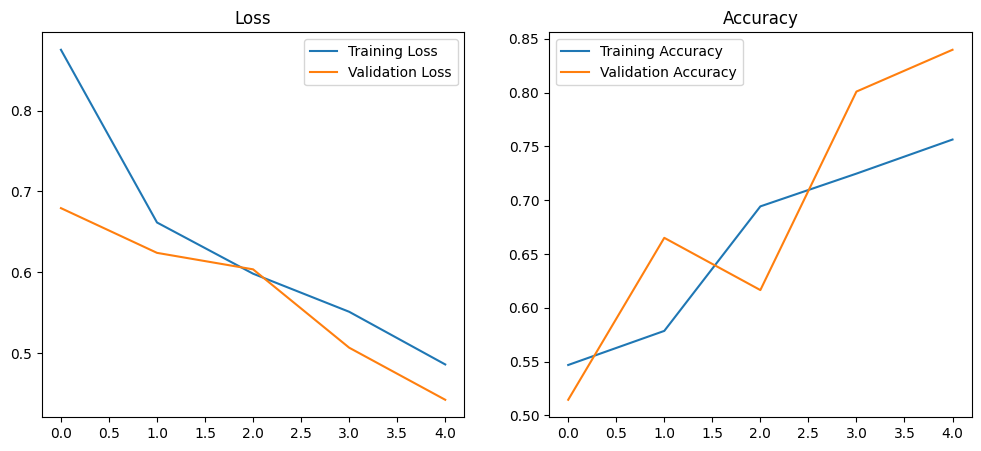

Test Loss: 0.4421, Test Accuracy: 0.8398



In [13]:
from tensorflow.keras.applications import MobileNetV2, ResNet50

experiments = [(ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3)), 'ResNet50')]
for base_model, model_name in experiments:
    print(f"\nEvaluating {model_name}\n")
    
    model = build_transfer_model(base_model)
    history = compile_and_train(model, 0.01, 32, 5)
    plot_metrics(history)
    test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n")